<table align="left">
  <td>
    <a href="https://is.gd/TOERXg" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Applied Machine Learning Techniques to Breast Cancer Recurrence Classification


## Data Science Project - 4 Classes
ELE2345

Diego R. Páez Ardila - 2120653

20/05/2022

<a href="https://ibb.co/Bw43dyX"><img src="https://i.ibb.co/9GwgzbF/Metodolog-a-3.jpg" alt="Metodolog-a-3"  width="400" border="2"></a>

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
np.random.seed(42)

from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report,cohen_kappa_score, accuracy_score  
from sklearn.metrics import roc_curve, roc_auc_score, f1_score,precision_score,recall_score  
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# 1- General Pre-Processing (GPP)

The dataset is studied to identify missing data, analyze the correlation between the attributes and the target class, observe if there is an imbalance in the target class and identify if it is necessary to apply regularization to the data.

In [5]:
df_4classes = pd.read_excel('/home/diripar8/Cancer-Classification/dadoscancer_4classes.xlsx')
df_4classes.head()

,Cancer Type Detailed,Subtype,Diagnosis Age,Sex,Ethnicity Category,Race Category,Neoplasm Cancer Code,Aneuploidy Score,Buffa Hypoxia Score,Ragnum Hypoxia Score,Winter Hypoxia Score,Fraction Genome Altered,In PanCan Pathway Analysis,Mutation Count,Post Initial Therapy,Prior Diagnosis,Radiation Therapy,Tissue Prospective Indicator,Class
0,2,2,55,0,1,2,11,19,-21,0,-28,0.7787,1,24,0,0,0,0,1
1,1,1,50,0,1,1,5,22,5,18,20,0.7164,1,458,0,0,1,0,3
2,0,0,54,0,1,0,4,16,27,14,22,0.4163,1,62,1,0,1,0,1
3,1,2,66,0,0,2,1,3,-27,-8,-20,0.0862,1,41,0,0,1,0,3
4,1,0,36,0,1,1,9,9,17,12,4,0.6407,1,128,1,0,1,0,0


In [6]:
df_4classes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Cancer Type Detailed          344 non-null    int64  
 1   Subtype                       344 non-null    int64  
 2   Diagnosis Age                 344 non-null    int64  
 3   Sex                           344 non-null    int64  
 4   Ethnicity Category            344 non-null    int64  
 5   Race Category                 344 non-null    int64  
 6   Neoplasm Cancer Code          344 non-null    int64  
 7   Aneuploidy Score              344 non-null    int64  
 8   Buffa Hypoxia Score           344 non-null    int64  
 9   Ragnum Hypoxia Score          344 non-null    int64  
 10  Winter Hypoxia Score          344 non-null    int64  
 11  Fraction Genome Altered       344 non-null    float64
 12  In PanCan Pathway Analysis    344 non-null    int64  
 13  Mutat

In [7]:
df_4classes.nunique()

Cancer Type Detailed              5
Subtype                           5
Diagnosis Age                    61
Sex                               2
Ethnicity Category                2
Race Category                     3
Neoplasm Cancer Code             12
Aneuploidy Score                 33
Buffa Hypoxia Score              44
Ragnum Hypoxia Score             27
Winter Hypoxia Score             47
Fraction Genome Altered         335
In PanCan Pathway Analysis        2
Mutation Count                  120
Post Initial Therapy              2
Prior Diagnosis                   2
Radiation Therapy                 2
Tissue Prospective Indicator      2
Class                             4
dtype: int64

In [8]:
df_4classes.isnull().sum()

Cancer Type Detailed            0
Subtype                         0
Diagnosis Age                   0
Sex                             0
Ethnicity Category              0
Race Category                   0
Neoplasm Cancer Code            0
Aneuploidy Score                0
Buffa Hypoxia Score             0
Ragnum Hypoxia Score            0
Winter Hypoxia Score            0
Fraction Genome Altered         0
In PanCan Pathway Analysis      0
Mutation Count                  0
Post Initial Therapy            0
Prior Diagnosis                 0
Radiation Therapy               0
Tissue Prospective Indicator    0
Class                           0
dtype: int64

## Histograms Matrix 

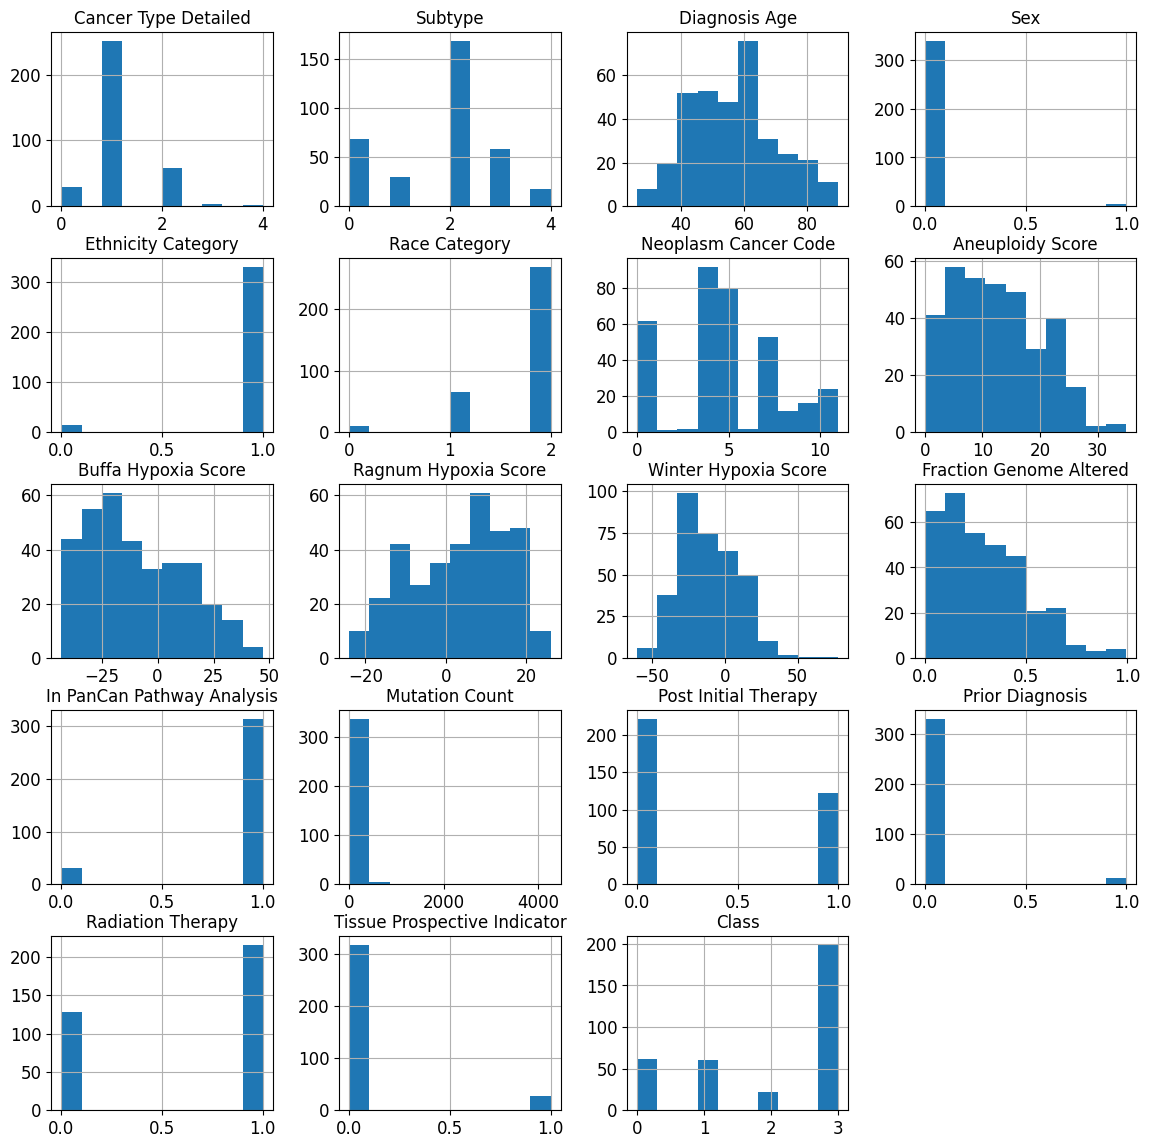

In [9]:
df_4classes.hist(figsize=(14,14))
plt.show()

## Histogram Analysis 

Out of 18 attributes of the dataset, 6 continuous variables and 12 categorical variables were identified.   

### Sex Attribute

In the histogram of the dataset it was observed that the **sex attribute** has records for both women and men. Although there is a possibility that breast cancer occurs in men, the number of records present in the dataset is not significant, therefore, we proceed to identify how many male records exist in the dataset and eliminate them. By eliminating the records associated with men, the sex variable only presents one category, therefore, it is discarded.

### Target Class

- Sem recorrência. 
- Recorrência cedo. 
- Recorrência média. 
- Recorrência tardia.



In [10]:
counter = Counter(df_4classes["Sex"])
print(counter)
print('%s : %d' % ('Women', counter[0]))
print('%s : %d' % ('Men', counter[1]))

#Smote
idx_0 = np.where(df_4classes.Sex == 0)
idx_1 = np.where(df_4classes.Sex == 1)

Counter({0: 340, 1: 4})
Women : 340
Men : 4


In [11]:
df_sexOut = df_4classes.drop(["Sex"], axis=1)
df_sexOut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Cancer Type Detailed          344 non-null    int64  
 1   Subtype                       344 non-null    int64  
 2   Diagnosis Age                 344 non-null    int64  
 3   Ethnicity Category            344 non-null    int64  
 4   Race Category                 344 non-null    int64  
 5   Neoplasm Cancer Code          344 non-null    int64  
 6   Aneuploidy Score              344 non-null    int64  
 7   Buffa Hypoxia Score           344 non-null    int64  
 8   Ragnum Hypoxia Score          344 non-null    int64  
 9   Winter Hypoxia Score          344 non-null    int64  
 10  Fraction Genome Altered       344 non-null    float64
 11  In PanCan Pathway Analysis    344 non-null    int64  
 12  Mutation Count                344 non-null    int64  
 13  Post 

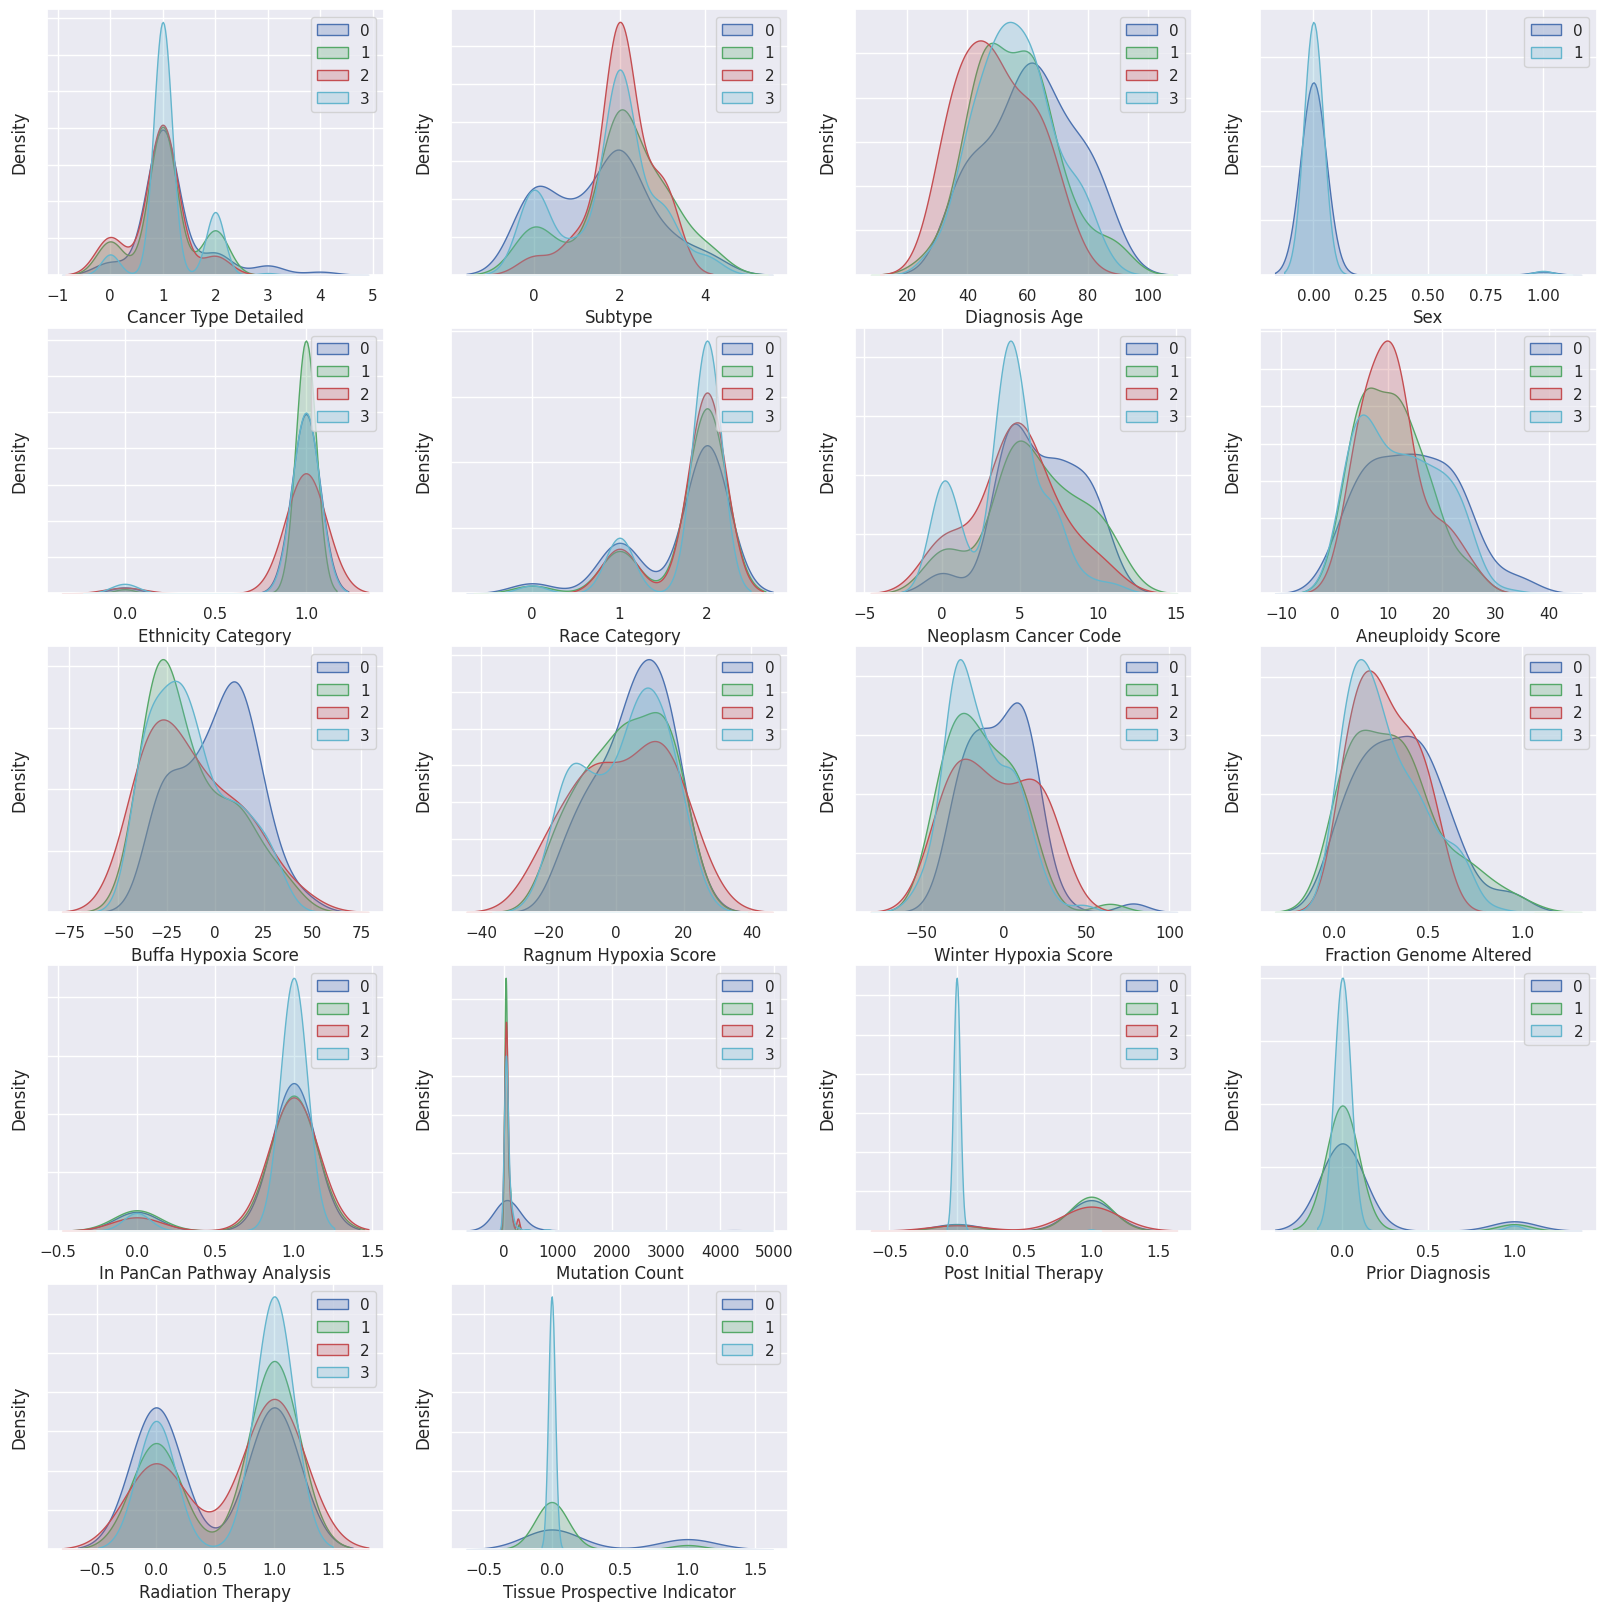

In [12]:
sns.set(style="darkgrid")
plt.subplots(5,4,figsize=(20,20))

for idx, col in enumerate(df_4classes.columns):
  ax = plt.subplot(5,4,idx+1)
  ax.yaxis.set_ticklabels([])
  fig = sns.kdeplot(df_4classes.loc[df_4classes.Class == 0][col], shade=True, color="b")
  fig = sns.kdeplot(df_4classes.loc[df_4classes.Class == 1][col], shade=True, color="g")
  fig = sns.kdeplot(df_4classes.loc[df_4classes.Class == 2][col], shade=True, color="r")
  fig = sns.kdeplot(df_4classes.loc[df_4classes.Class == 3][col], shade=True, color="c")
  ax.legend(labels=['0','1','2','3']) # No Recurrence; # Recurrence

plt.subplot(5,4,19).set_visible(False)
plt.subplot(5,4,20).set_visible(False)
plt.show()

## Target Class Analysis

It was identified that the distribution of data in the target class is unbalanced.

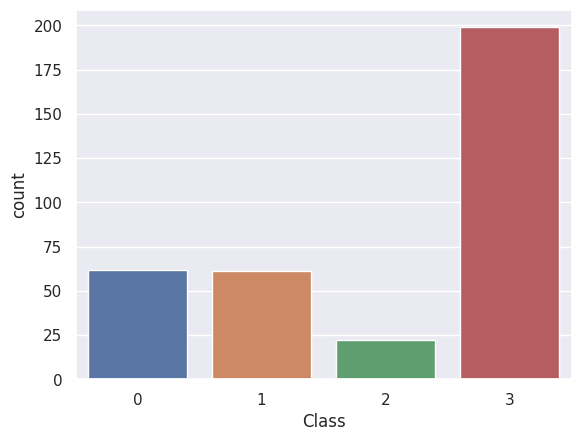

In [14]:
sns.countplot(x=df_sexOut.Class);

In [15]:
# Generate and plot a synthetic imbalanced classification dataset
counter = Counter(df_sexOut["Class"])
print('%s : %d' % ('Early Recurrence', counter[0]))
print('%s : %d' % ('Middle Recurrence', counter[1]))
print('%s : %d' % ('Late Recurrence', counter[2]))
print('%s : %d' % ('Non Recurrence', counter[3]))

Early Recurrence : 62
Middle Recurrence : 61
Late Recurrence : 22
Non Recurrence : 199


## K-Means

The third class has a low number of instances, therefore the K-Means clutering algorithm is used to reduce the classes to 3.

In [ ]:
from sklearn.cluster import KMeans

Target = np.array(df_sexOut["Class"])
km = KMeans(n_clusters=3, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=1)
Target_knn = km.fit_predict(Target.reshape(-1, 1))
Target_knn = pd.DataFrame(Target_knn, columns = ["Target"])

df_knn=pd.concat([df_sexOut.drop(["Class"],axis=1), Target_knn], axis = 1)

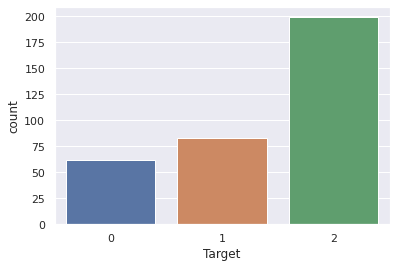

In [ ]:
sns.countplot(df_knn["Target"])

In [ ]:
counter = Counter(df_knn["Target"])
print('%s : %d' % ('Early Recurrence', counter[0]))
print('%s : %d' % ('Mid/late Recurrence', counter[1]))
print('%s : %d' % ('Non Recurrence', counter[2]))

Non Recurrence : 62
Early Recurrence : 83
Late Recurrence : 199


## Data Transformation

Handle discrete and continuous inputs together:

- Rescale bounded continuous features: All continuous input that are bounded, rescale them to [-1, 1] through $x = \frac{(2x - max - min)}{(max - min)}$.

- Standardize all continuous features: All continuous input should be standardized and by this I mean, for every continuous feature, compute its mean (u) and standard deviation (s) and do $x = \frac{(x - u)}{s}$.

- Binarize categorical/discrete features: For all categorical features, represent them as multiple boolean features. For example, instead of having one feature called marriage_status, have 3 boolean features - married_status_single, married_status_married, married_status_divorced and appropriately set these features to 1 or -1. As you can see, for every categorical feature, you are adding k binary feature where k is the number of values that the categorical feature takes.

[Reference](https://www.quora.com/Machine-Learning/What-are-good-ways-to-handle-discrete-and-continuous-inputs-together/answer/Arun-Iyer-1)

In [ ]:
df_categorical = df_knn.drop(["Diagnosis Age","Aneuploidy Score","Buffa Hypoxia Score","Ragnum Hypoxia Score","Winter Hypoxia Score","Fraction Genome Altered", "Mutation Count"], axis=1)
df_continuous  = df_knn.drop(df_categorical.columns,axis=1)
df_categorical = df_categorical.drop("Target", axis=1)
df_categorical.head()

,Cancer Type Detailed,Subtype,Ethnicity Category,Race Category,Neoplasm Cancer Code,In PanCan Pathway Analysis,Post Initial Therapy,Prior Diagnosis,Radiation Therapy,Tissue Prospective Indicator
0,2,2,1,2,11,1,0,0,0,0
1,1,1,1,1,5,1,0,0,1,0
2,0,0,1,0,4,1,1,0,1,0
3,1,2,0,2,1,1,0,0,1,0
4,1,0,1,1,9,1,1,0,1,0


## Encode categorical integer features using a one-hot.
  - - Cancer Type Detailed
  - - Subtype
  - - Race Category
  - - Neoplasm Cancer Code

2. The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features.

3. The output will be a sparse matrix where each column corresponds to one possible value of one feature.

In [ ]:
df_categorical_int= df_categorical[['Cancer Type Detailed','Subtype',"Race Category",'Neoplasm Cancer Code']]
df_categorical_int.head()

,Cancer Type Detailed,Subtype,Race Category,Neoplasm Cancer Code
0,2,2,2,11
1,1,1,1,5
2,0,0,0,4
3,1,2,2,1
4,1,0,1,9


In [ ]:
# TODO: create a OneHotEncoder object, and fit it to all of X
# Ref: https://www.statology.org/one-hot-encoding-in-python/
# 1. INSTANTIATE
encoder = preprocessing.OneHotEncoder()

# 2. FIT
encoder.fit(df_categorical_int)

# 3. Transform
df_cat_int_onehot = pd.DataFrame(encoder.transform(df_categorical_int).toarray())

#merge one-hot encoded columns back with original DataFrame
df_1hot = df_categorical.join(df_cat_int_onehot)
df_categorical_1hot = df_1hot.drop(['Cancer Type Detailed','Subtype',"Race Category",'Neoplasm Cancer Code'], axis=1)
df_categorical_1hot.head()

,Ethnicity Category,In PanCan Pathway Analysis,Post Initial Therapy,Prior Diagnosis,Radiation Therapy,Tissue Prospective Indicator,0,1,2,3,...,15,16,17,18,19,20,21,22,23,24
0,1,1,0,0,0,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1,0,0,1,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,1,0,1,0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,1,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,1,0,1,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Standardize all continuous features

In [ ]:
df_scaled = preprocessing.scale(df_continuous)
df_continuous = pd.DataFrame(df_scaled, columns=df_continuous.columns)
df_continuous.head()

,Diagnosis Age,Aneuploidy Score,Buffa Hypoxia Score,Ragnum Hypoxia Score,Winter Hypoxia Score,Fraction Genome Altered,Mutation Count
0,-0.108690,0.911473,-0.521661,-0.238922,-0.787674,2.307478,-0.208074
1,-0.476698,1.312941,0.703906,1.266068,1.525751,2.011554,1.578998
2,-0.182292,0.510005,1.740924,0.931626,1.622143,0.586084,-0.051603
3,0.700925,-1.229691,-0.804484,-0.907807,-0.402103,-0.981885,-0.138074
4,-1.507117,-0.426755,1.269552,0.764405,0.754609,1.651981,0.220164


## Dataset GPP

Standardized continuous data are merged with categorical data after onehot is applied. 

In [ ]:
df_GPP = df_continuous.join(df_categorical_1hot)
df_GPP.head()

,Diagnosis Age,Aneuploidy Score,Buffa Hypoxia Score,Ragnum Hypoxia Score,Winter Hypoxia Score,Fraction Genome Altered,Mutation Count,Ethnicity Category,In PanCan Pathway Analysis,Post Initial Therapy,...,15,16,17,18,19,20,21,22,23,24
0,-0.108690,0.911473,-0.521661,-0.238922,-0.787674,2.307478,-0.208074,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.476698,1.312941,0.703906,1.266068,1.525751,2.011554,1.578998,1,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.182292,0.510005,1.740924,0.931626,1.622143,0.586084,-0.051603,1,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.700925,-1.229691,-0.804484,-0.907807,-0.402103,-0.981885,-0.138074,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.507117,-0.426755,1.269552,0.764405,0.754609,1.651981,0.220164,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# 2-Model Configuration


## Model Performance **Function**



- Confusion Matrix:
- Classification Report:
- Cohen Kappa Score:
- AUROC Score: 

In [ ]:
def performanceCal(ytest, ypredict,yprob):
  """
    Calculation of performance metrics:
    - Confusion Matrix:
    - Accuracy Score: https://is.gd/YwoQJf
    - Precision Score: https://is.gd/Xz6Nu0
    - F1-Score: https://is.gd/YVGWCs
    - Recall Score: https://is.gd/9PUCgT 
    - Cohen Kappa Score:
    - AUROC Score: https://is.gd/JIAktb
    Arguments:
        ytest: ndarray - list
        ypredict: ndarray - list
        ypredict_probability
    Returns:
        List with result of performance metrics: matrixconfu,accuracyscore,
        precisionscore,f1score,recallscore,cohenkappa,auroc_score
    """

  matrixconfu = confusion_matrix(ytest, ypredict)
  matrixreport = classification_report(ytest, ypredict)
  accuracyscore = round(accuracy_score(ytest, ypredict),3)
  f1score = round(f1_score(ytest, ypredict, average='weighted'),3)
  precisionscore = round(precision_score(ytest, ypredict, average='weighted'),3)
  recallscore = round(recall_score(ytest, ypredict, average='weighted'),3)
  

  cohenkappa= round(cohen_kappa_score(ytest, ypredict),3)
  auroc_score = round(roc_auc_score(ytest, yprob,multi_class="ovr"),3)


  result = [matrixconfu,matrixreport,accuracyscore,precisionscore,f1score,recallscore,cohenkappa,auroc_score]
  return result


## Model Classifiers **Function**
Function for the application of the models in a systematic way.

In [ ]:
def modelClas(model,x,y,xtrain,ytrain,xtest):
  """
  Model Evaluation:

  Arguments:
      model: sklearn classifier model
      X_: ndarray - list
      y_: ndarray - list
      xtrain: ndarray - list
      ytrain: ndarray - list
      xtest: ndarray - list
  Returns:
      List with result accuracy kfold and model predictions
  """
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  scores_origin = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
  
  accuracy_kfold = round(mean(scores_origin),3)
  std_kfold = round(std(scores_origin),3)
  model.fit(xtrain, ytrain)
  model_predic = model.predict(xtest)
  pred_prob = model.predict_proba(xtest)

  # ['accuracy', 'average_precision', 'f1','recall', 'roc_auc']

  return [accuracy_kfold,std_kfold, model_predic,pred_prob]

In [ ]:
def heatmapgraph(data):
  ax = sns.heatmap(data, annot=True,xticklabels=['No Recurrence','Early Recurrence','Late Recurrence'],
                 yticklabels=['No Recurrence','Early Recurrence','Late Recurrence'],cbar=False, cmap='Blues')
  ax.set_xlabel("Prediction")
  ax.set_ylabel("Actual")

## MC- 1

**MC-1 (Training)**: Training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) models using the original dataset.

Calculation of performance metrics using the original dataset, to have an initial reference point. 

In [ ]:
X_origin = df_knn.drop(["Target"],axis=1)
y_origin = df_knn["Target"]
X_train, X_test, y_train, y_test = train_test_split(X_origin, y_origin, test_size=0.2, random_state=1)

modelLR_MC1 = LogisticRegression(random_state=1)
modelNB_MC1 = GaussianNB()
modelSVC_MC1 = SVC(probability=True, random_state=1)
modelKNN_MC1 = KNeighborsClassifier()

models_MC1=[modelLR_MC1,modelNB_MC1,modelSVC_MC1,modelKNN_MC1]
#plt.subplots(2,2,figsize=(15,15))
modelsNames = ["Logistic Regression", "Naive Bayes", "SVM", "KNN"]
metricsResults = []

for idx, model in enumerate(models_MC1):
  modelResults = modelClas(model,X_origin,y_origin,X_train,y_train,X_test)
  metrics = performanceCal(y_test,modelResults[2],modelResults[3])
  metrics.insert(2,modelsNames[idx])
  metrics.insert(3,modelResults[0])
  metrics.insert(4,modelResults[1])
  metricsResults.append(metrics[2:])

  print('Conf Matrix and Class report ' + modelsNames[idx] + ": \n"  ,metrics[0])
  print(metrics[1])

Conf Matrix and Class report Logistic Regression: 
 [[ 5  5  1]
 [ 1 11  1]
 [ 0  0 45]]
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.69      0.85      0.76        13
           2       0.96      1.00      0.98        45

    accuracy                           0.88        69
   macro avg       0.83      0.77      0.78        69
weighted avg       0.89      0.88      0.87        69

Conf Matrix and Class report Naive Bayes: 
 [[ 4  7  0]
 [ 0 12  1]
 [ 1  0 44]]
              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.63      0.92      0.75        13
           2       0.98      0.98      0.98        45

    accuracy                           0.87        69
   macro avg       0.80      0.75      0.74        69
weighted avg       0.88      0.87      0.86        69

Conf Matrix and Class report SVM: 
 [[ 0  0 11]
 [ 0  0 13]
 [ 0  0 

In [ ]:
#create data
data = [metricsResults[0],metricsResults[1],metricsResults[2],metricsResults[3]]
  
#define header names
col_names = ["Models", "Accuracy CV","STD CV", "Accuracy", "Precision","Recall", "F1-Score", "Cohen Kappa Score", "AUC ROC Score" ]
  
#display table
MC1_Results = pd.DataFrame(data=data, columns=col_names)
MC1_Results

,Models,Accuracy CV,STD CV,Accuracy,Precision,Recall,F1-Score,Cohen Kappa Score,AUC ROC Score
0,Logistic Regression,0.808,0.067,0.884,0.887,0.875,0.884,0.767,0.883
1,Naive Bayes,0.788,0.063,0.870,0.884,0.859,0.870,0.745,0.960
2,SVM,0.578,0.073,0.652,0.425,0.515,0.652,0.000,0.553
3,KNN,0.467,0.069,0.536,0.534,0.535,0.536,0.085,0.543


## General Split Train Test Dataset

In [ ]:
# Split data 80-20 %
X = df_GPP
y = df_knn["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(np.shape(X_train))
print(np.shape(y_train))

print(np.shape(X_test))
print(np.shape(y_test))

(275, 38)
(275,)
(69, 38)
(69,)


## MC-2

In [ ]:
modelLR_MC2 = LogisticRegression(random_state=1)
modelNB_MC2 = GaussianNB()
modelSVC_MC2 = SVC(probability=True,random_state=1)
modelKNN_MC2 = KNeighborsClassifier()

models_MC2=[modelLR_MC2,modelNB_MC2,modelSVC_MC2,modelKNN_MC2]
#plt.subplots(2,2,figsize=(15,15))
modelsNames = ["Logistic Regression", "Naive Bayes", "SVM", "KNN"]
metricsResults = []

for idx, model in enumerate(models_MC2):
  modelResults = modelClas(model,X,y,X_train,y_train,X_test)
  metrics = performanceCal(y_test,modelResults[2],modelResults[3])
  metrics.insert(2,modelsNames[idx])
  metrics.insert(3,modelResults[0])
  metrics.insert(4,modelResults[1])
  metricsResults.append(metrics[2:])

  print('Conf Matrix and Class report ' + modelsNames[idx] + ": \n"  ,metrics[0])
  print(metrics[1])

Conf Matrix and Class report Logistic Regression: 
 [[ 5  6  0]
 [ 1 10  2]
 [ 0  2 43]]
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.56      0.77      0.65        13
           2       0.96      0.96      0.96        45

    accuracy                           0.84        69
   macro avg       0.78      0.73      0.73        69
weighted avg       0.86      0.84      0.84        69

Conf Matrix and Class report Naive Bayes: 
 [[ 5  6  0]
 [ 2 10  1]
 [ 2  1 42]]
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        11
           1       0.59      0.77      0.67        13
           2       0.98      0.93      0.95        45

    accuracy                           0.83        69
   macro avg       0.71      0.72      0.71        69
weighted avg       0.84      0.83      0.83        69

Conf Matrix and Class report SVM: 
 [[ 4  6  1]
 [ 1 11  1]
 [ 0  0 

In [ ]:
#create data
data = [metricsResults[0],metricsResults[1],metricsResults[2],metricsResults[3]]
  
#define header names
col_names = ["Models", "Accuracy CV","STD CV", "Accuracy", "Precision","Recall", "F1-Score", "Cohen Kappa Score", "AUC ROC Score" ]
  
#display table
MC2_Results = pd.DataFrame(data=data, columns=col_names)
MC2_Results

,Models,Accuracy CV,STD CV,Accuracy,Precision,Recall,F1-Score,Cohen Kappa Score,AUC ROC Score
0,Logistic Regression,0.822,0.060,0.841,0.861,0.839,0.841,0.688,0.943
1,Naive Bayes,0.621,0.135,0.826,0.836,0.828,0.826,0.670,0.838
2,SVM,0.808,0.063,0.870,0.874,0.856,0.870,0.738,0.956
3,KNN,0.680,0.086,0.667,0.658,0.656,0.667,0.322,0.727


##MC-3

A feature selection techniques (PCA) is applied to the GPP dataset to select the most significant attributes for the target class in the dataset. 


**MCP-3 (Training + GPP + Feature Extraction)**: Training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) models using the dataset with GPP + Feature Extraction.

In [ ]:
# Make an instance of the Model
pca = PCA(.95)

In [ ]:
pca.fit(X_train)

PCA(n_components=0.95)

In [ ]:
pcaColumns = []
limit = pca.n_components_
for i in range (0,limit):
  name = "PCA" + str(i)
  pcaColumns.append(name)

In [ ]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca = pd.DataFrame(data = X_train_pca, columns = pcaColumns)
X_test_pca =  pd.DataFrame(data = X_test_pca, columns = pcaColumns)
X_train_pca.head()

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18
0,2.336140,-0.185195,-0.288418,0.813684,0.378214,-1.309581,-0.419655,0.227584,-0.327991,-0.684859,-0.039167,0.582865,-0.006108,-0.132619,0.071150,-0.106995,-0.368012,-0.313111,-0.115478
1,-0.638835,-0.426544,0.349164,0.846421,-0.403638,1.006611,-0.194936,-0.026324,0.318923,0.432620,0.783174,0.665122,-0.375206,0.180792,-0.360290,-0.117460,-0.309866,-0.330943,-0.076339
2,2.019905,0.382188,-1.140450,-0.661648,-0.379624,0.281515,-0.262251,-0.363293,0.541636,0.583737,0.688315,0.433853,-0.487775,0.261833,-0.300455,-0.117143,-0.077294,-0.045736,-0.158613
3,-0.716667,-0.148112,-0.044311,0.713737,0.373512,-0.741325,0.364294,-0.026643,-0.905010,-0.256450,0.279972,0.493636,1.249213,-0.605555,0.295224,-0.328248,-0.347733,-0.026616,0.878326
4,-2.240560,0.471986,-0.428633,-0.125081,0.251565,-0.896413,-0.515226,0.400978,0.143702,-0.688418,0.256889,-0.678559,-0.069631,-0.084445,0.029907,0.104594,-0.186845,-0.011975,-0.117481


In [ ]:
y_train_pca = y_train
y_test_pca = y_test

print(np.shape(X_train_pca))
print(np.shape(y_train_pca))

print(np.shape(X_test_pca))
print(np.shape(y_test_pca))


(275, 19)
(275,)
(69, 19)
(69,)


In [ ]:
modelLR_MC3 = LogisticRegression(random_state=1)
modelNB_MC3 = GaussianNB()
modelSVC_MC3 = SVC(probability=True,random_state=1)
modelKNN_MC3 = KNeighborsClassifier()

models_MC3=[modelLR_MC3,modelNB_MC3,modelSVC_MC3,modelKNN_MC3]
#plt.subplots(2,2,figsize=(15,15))
modelsNames = ["Logistic Regression", "Naive Bayes", "SVM", "KNN"]
metricsResults = []

for idx, model in enumerate(models_MC3):
  modelResults = modelClas(model,X_train_pca,y_train_pca,X_train_pca,y_train_pca,X_test_pca)
  metrics = performanceCal(y_test_pca,modelResults[2],modelResults[3])
  metrics.insert(2,modelsNames[idx])
  metrics.insert(3,modelResults[0])
  metrics.insert(4,modelResults[1])
  metricsResults.append(metrics[2:])
  print('Conf Matrix and Class report ' + modelsNames[idx] + ": \n"  ,metrics[0])
  print(metrics[1])

Conf Matrix and Class report Logistic Regression: 
 [[ 4  7  0]
 [ 2  9  2]
 [ 0  1 44]]
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        11
           1       0.53      0.69      0.60        13
           2       0.96      0.98      0.97        45

    accuracy                           0.83        69
   macro avg       0.72      0.68      0.68        69
weighted avg       0.83      0.83      0.82        69

Conf Matrix and Class report Naive Bayes: 
 [[ 1  7  3]
 [ 0 10  3]
 [ 2  0 43]]
              precision    recall  f1-score   support

           0       0.33      0.09      0.14        11
           1       0.59      0.77      0.67        13
           2       0.88      0.96      0.91        45

    accuracy                           0.78        69
   macro avg       0.60      0.61      0.57        69
weighted avg       0.74      0.78      0.75        69

Conf Matrix and Class report SVM: 
 [[ 4  6  1]
 [ 1 11  1]
 [ 0  0 

In [ ]:
#create data
data = [metricsResults[0],metricsResults[1],metricsResults[2],metricsResults[3]]
  
#define header names
col_names = ["Models", "Accuracy CV","STD CV", "Accuracy", "Precision","Recall", "F1-Score", "Cohen Kappa Score", "AUC ROC Score" ]
  
#display table
MC3_Results = pd.DataFrame(data=data, columns=col_names)
MC3_Results

,Models,Accuracy CV,STD CV,Accuracy,Precision,Recall,F1-Score,Cohen Kappa Score,AUC ROC Score
0,Logistic Regression,0.811,0.070,0.826,0.830,0.819,0.826,0.656,0.955
1,Naive Bayes,0.749,0.094,0.783,0.736,0.745,0.783,0.550,0.911
2,SVM,0.775,0.091,0.870,0.874,0.856,0.870,0.738,0.949
3,KNN,0.670,0.086,0.696,0.681,0.683,0.696,0.397,0.740


## MC-4

**MCP-4 (Training + GPP + Feature Extraction + Oversample)**: Training of Logistic Regression (LR), Naive Bayes (NB), Support Vector Machine (SVM), k nearest neighbors (KNN) models using the dataset with GPP + Feature Extraction. To avoid the problem of imbalance in the target class, the SMOTE method is used. 

In [ ]:
# import library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train_pca)

print('Original dataset shape', Counter(y_train_pca))
print('Resample dataset shape', Counter(y_train_smote))

Original dataset shape Counter({2: 154, 1: 70, 0: 51})
Resample dataset shape Counter({1: 154, 2: 154, 0: 154})


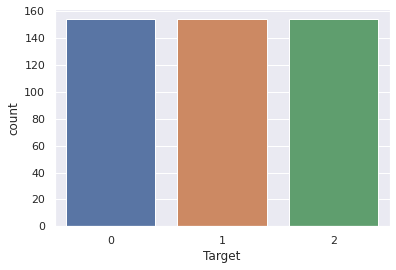

In [ ]:
sns.countplot(x=y_train_smote)

In [ ]:
modelLR_MC4 = LogisticRegression(random_state=1)
modelNB_MC4 = GaussianNB()
modelSVC_MC4 = SVC(probability=True,random_state=1)
modelKNN_MC4 = KNeighborsClassifier()

models_MC4=[modelLR_MC4,modelNB_MC4,modelSVC_MC4,modelKNN_MC4]
#plt.subplots(2,2,figsize=(15,15))
modelsNames = ["Logistic Regression", "Naive Bayes", "SVM", "KNN"]
metricsResults = []

for idx, model in enumerate(models_MC4):
  modelResults = modelClas(model,X_train_pca,y_train_pca,x_train_smote,y_train_smote,X_test_pca)
  metrics = performanceCal(y_test_pca,modelResults[2],modelResults[3])
  metrics.insert(2,modelsNames[idx])
  metrics.insert(3,modelResults[0])
  metrics.insert(4,modelResults[1])
  metricsResults.append(metrics[2:])
  print('Conf Matrix and Class report ' + modelsNames[idx] + ": \n"  ,metrics[0])
  print(metrics[1])

Conf Matrix and Class report Logistic Regression: 
 [[ 5  6  0]
 [ 3 10  0]
 [ 0  1 44]]
              precision    recall  f1-score   support

           0       0.62      0.45      0.53        11
           1       0.59      0.77      0.67        13
           2       1.00      0.98      0.99        45

    accuracy                           0.86        69
   macro avg       0.74      0.73      0.73        69
weighted avg       0.86      0.86      0.85        69

Conf Matrix and Class report Naive Bayes: 
 [[ 3  8  0]
 [ 3  9  1]
 [ 2  1 42]]
              precision    recall  f1-score   support

           0       0.38      0.27      0.32        11
           1       0.50      0.69      0.58        13
           2       0.98      0.93      0.95        45

    accuracy                           0.78        69
   macro avg       0.62      0.63      0.62        69
weighted avg       0.79      0.78      0.78        69

Conf Matrix and Class report SVM: 
 [[ 6  4  1]
 [ 4  9  0]
 [ 1  0 

In [ ]:
#create data
data = [metricsResults[0],metricsResults[1],metricsResults[2],metricsResults[3]]
  
#define header names
col_names = ["Models", "Accuracy CV","STD CV", "Accuracy", "Precision","Recall", "F1-Score", "Cohen Kappa Score", "AUC ROC Score"]
  
#display table
MC4_Results = pd.DataFrame(data=data, columns=col_names)
MC4_Results

,Models,Accuracy CV,STD CV,Accuracy,Precision,Recall,F1-Score,Cohen Kappa Score,AUC ROC Score
0,Logistic Regression,0.811,0.070,0.855,0.863,0.854,0.855,0.721,0.946
1,Naive Bayes,0.749,0.094,0.783,0.791,0.782,0.783,0.587,0.904
2,SVM,0.775,0.091,0.855,0.855,0.855,0.855,0.718,0.919
3,KNN,0.670,0.086,0.652,0.748,0.679,0.652,0.416,0.728


# Performance of Trained Models 

Performance comparison of the trained models with k-fold cross validation

In [ ]:
mc1 = MC1_Results[["Accuracy CV","STD CV"]]
mc2 = MC2_Results[["Accuracy CV","STD CV"]]
mc3 = MC3_Results[["Accuracy CV","STD CV"]]
mc4 = MC4_Results[["Accuracy CV","STD CV"]]

headers= ["MC-1 CV","STD CV","MC-2 CV","STD CV","MC-3 CV","STD CV","MC-4 CV","STD CV"]
index = ["LR","NB","SVM","KNN"]

acc_CV = pd.concat([mc1,mc2,mc3,mc4], axis=1)
acc_CV.columns = headers
acc_CV.index = index

acc_CV

,MC-1 CV,STD CV,MC-2 CV,STD CV,MC-3 CV,STD CV,MC-4 CV,STD CV
LR,0.808,0.067,0.822,0.060,0.811,0.070,0.811,0.070
NB,0.788,0.063,0.621,0.135,0.749,0.094,0.749,0.094
SVM,0.578,0.073,0.808,0.063,0.775,0.091,0.775,0.091
KNN,0.467,0.069,0.680,0.086,0.670,0.086,0.670,0.086


#3-Parameter tuning using CV



## MC-1

### Logistic Regresion

In [ ]:
from sklearn.model_selection import GridSearchCV
# parameter grid
parameters = {
    'penalty' : ['l1','l2', "elasticnet"], 
    'C'       : np.logspace(-3,3,10),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', "saga"],
}

logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
clf.fit(X_origin,y_origin)

print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)
print(clf.best_estimator_)

Tuned Hyperparameters : {'C': 2.154434690031882, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy : 0.8406722689075629
LogisticRegression(C=2.154434690031882, solver='liblinear')


### Naive Bayes

In [ ]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=1000)
}

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_origin,y_origin)
print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
GaussianNB(var_smoothing=8.126619200091945e-07)


### SVM

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

# fitting the model for grid search
grid.fit(X_origin,y_origin)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.0001)


### KNN

In [ ]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_origin,y_origin)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

print(clf.best_estimator_)

Best leaf_size: 1
Best p: 1
Best n_neighbors: 22
KNeighborsClassifier(leaf_size=1, n_neighbors=22, p=1)


## MC-2

### Logistic Regresion Tunning

In [ ]:
# parameter grid
parameters = {
    'penalty' : ['l1','l2', "elasticnet"], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', "saga"],
}

logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
clf.fit(X_train,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)
print(clf.best_estimator_)

Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}
Accuracy : 0.8259259259259257
LogisticRegression(penalty='l1', solver='saga')


### Naive Bayes

In [ ]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=1000)
}

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
GaussianNB(var_smoothing=0.03851107002325571)


### SVM

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1, gamma=0.1)


### KNN

In [ ]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

print(clf.best_estimator_)

Best leaf_size: 1
Best p: 1
Best n_neighbors: 10
KNeighborsClassifier(leaf_size=1, n_neighbors=10, p=1)


## MC-3

### Logistic Regresion

In [ ]:
# parameter grid
parameters = {
    'penalty' : ['l1','l2', "elasticnet"], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', "saga"],
}

logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
clf.fit(X_train_pca,y_train_pca)

print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

print(clf.best_estimator_)

Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.8257936507936507
LogisticRegression(penalty='l1', solver='liblinear')


### Naive Bayes

In [ ]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train_pca,y_train_pca)
print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.01)


### SVM

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

# fitting the model for grid search
grid.fit(X_train_pca,y_train_pca)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.001)


### KNN

In [ ]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train_pca,y_train_pca)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

print(clf.best_estimator_)

Best leaf_size: 1
Best p: 1
Best n_neighbors: 6
KNeighborsClassifier(leaf_size=1, n_neighbors=6, p=1)


## MC-4

### Logistic Regresion

In [ ]:
# parameter grid
parameters = {
    'penalty' : ['l1','l2', "elasticnet"], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', "saga"],
}

logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
clf.fit(x_train_smote,y_train_smote)

print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

print(clf.best_estimator_)

Tuned Hyperparameters : {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.8164662349676226
LogisticRegression(C=1000.0, penalty='l1', solver='liblinear')


### Naive Bayes

In [ ]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(x_train_smote,y_train_smote)
print(nbModel_grid.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.003511191734215131)


### SVM

In [ ]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1)

# fitting the model for grid search
grid.fit(x_train_smote,y_train_smote)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=100, gamma=0.1)


### KNN

In [ ]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10,scoring='accuracy')
#Fit the model
best_model = clf.fit(x_train_smote,y_train_smote)
#Print The value of best Hyperparameters
print(clf.best_score_)
print(clf.best_estimator_)

0.8811285846438484
KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)


In [ ]:
%%shell
jupyter nbconvert --to html /content/Projeto_DS_4clases.ipynb

[NbConvertApp] Converting notebook /content/Projeto_DS_4clases.ipynb to html
[NbConvertApp] Writing 957161 bytes to /content/Projeto_DS_4clases.html
